<a href="https://colab.research.google.com/github/jpincru/TFM_UOC/blob/main/MODELO_PREDICTIVO_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install -q matplotlib tensorflow numpy

In [ ]:
#importación de librerias necesarias
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D
import matplotlib.pyplot as plt
import os, sys
from os import listdir
from matplotlib import image
from PIL import Image
import cv2
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Input
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from keras import regularizers
from tqdm import tqdm
from keras.models import load_model
from keras.callbacks import Callback

%matplotlib inline

print('Check GPU runtime type... ')
if len(tf.config.list_physical_devices('GPU')) == 0:
  print('Change Runtype Type in top menu for GPU acceleration')
  print(' "Runtime" -> "Change Runtime Type" -> "GPU"')
else:
  print('OK!')

Check GPU runtime type... 
OK!


1. Se monta el directorio de drive para cargar los archivos

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


2. Se muestra una imagen de ejemplo

In [ ]:
# # %pylab inline
# # import matplotlib.pyplot as plt
# # import matplotlib.image as mpimg
# img = mpimg.imread('/content/drive/MyDrive/Master bioinfo/TFM/BATCHTFM1/ko/MAX_tl81_sabas_AFA663_.Position 3-1_centered_0_div_0_z_163.tif')
# imgplot = plt.imshow(img)
# plt.show()


# #Se comprueba la resolución y canales de una imagen:
# print(img.shape)


MAX_tl81_sabas_AFA663_Position 8-1_centered_0_div_0_z_73.tif


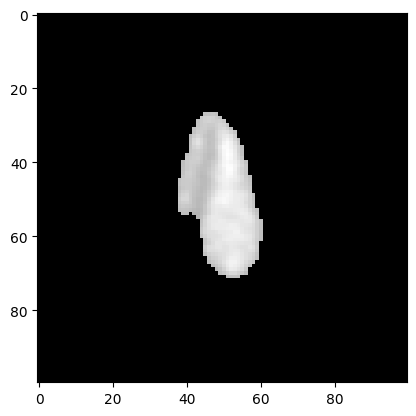

In [ ]:
#Se usa como directorio principal un directorio que contiene los subdirectorios wt y mutant
dataset = 'BATCH_DEF_6_MARZO'
DATADIR = "/content/drive/MyDrive/"+ dataset +"/"
CATEGORIES = ['wt','mutant']
wt_folder = '/content/drive/MyDrive/'+dataset+'/wt/'
mutant_folder = '/content/drive/MyDrive/'+dataset+'/mutant/'


for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    print(img)
    # img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_ANYCOLOR)
    img_array = mpimg.imread(os.path.join(path,img))
    # img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_ANYDEPTH)
    # img_array2 = img_array.astype(np.uint8)
    # plt.subplot(121)
    plt.imshow(img_array,cmap ="gray")
    # plt.subplot(122)
    # plt.imshow(img_array2,cmap ="gray")
    plt.show()
    # print(img_array.dtype)
    break
  break


In [ ]:
v_min = np.min(img_array)
v_max = np.max(img_array)
print("Min. and max. values before normalization are {} and {}.".format(v_min, v_max))

#Se comprueba la resolución inicial una vez se han reducido las imagenes a un solo canal:
print(img_array.shape)


Min. and max. values before normalization are 0 and 171.
(100, 100)


3. Se preprocesan las imágenes originales de 100x100x1 para convertirlas a 64x64x1.

4. Se normaliza mediante transformación min-max.

Min. and max. values before normalization are 0 and 168.
Min. and max. values after normalization are 0.0 and 1.0.


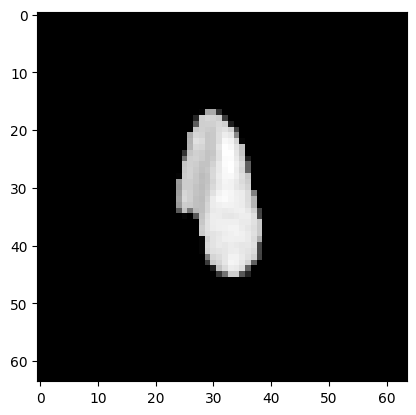

In [ ]:
# Resize a tamaño 64x64
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

#Se muestra una imagen con la nueva resolución como ejemplo:
plt.imshow(new_array,cmap ='gray')

# normalización min max:

v_min = np.min(new_array)
v_max = np.max(new_array)
print("Min. and max. values before normalization are {} and {}.".format(v_min, v_max))

# Normalization

new_array_norm = (new_array - v_min) / (v_max - v_min)
print("Min. and max. values after normalization are {} and {}.".format(np.min(new_array_norm), np.max(new_array_norm)))

In [ ]:
#Se crean los datos que van a ser utilizados y se hace el resize y normalización para cada una de las imágenes

data = []

def create_data():
  for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        # img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_ANYDEPTH)
        # img_array = img_array.astype(np.uint8)
        img_array = mpimg.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

        # Normalization
        v_min = np.min(new_array)
        v_max = np.max(new_array)
        # print("Min. and max. values before normalization are {} and {}.".format(v_min, v_max))

        new_array_norm = (new_array - v_min) / (v_max - v_min)
        # print("Min. and max. values after normalization are {} and {}.".format(np.min(new_array_norm), np.max(new_array_norm)))
        data.append([(new_array_norm), class_num])

      except Exception as e:
        pass
tqdm(create_data())

0it [00:00, ?it/s]

In [ ]:
# Se comprueba el tamaño de los datos
len(data)

2920

In [ ]:
### PARA TEST Y TRAINING

#Se mezclan las imagenes de wt y mutantes para posteriormente poder hacer un subset equilibrado para entrenamiento y test

import random
seed_value = 101
random.seed(seed_value)
random.shuffle(data)

#Se comprueba que la proporción en training (0:75) y test(75:100) sea similar.
n_total = len(data)
n_75 = round(int(n_total*0.75))
n_25 = round(int(n_total-n_75))

mut = 0
wt = 0

for sample in data[0:n_75]:
  if (sample[1] == 1):
    mut +=1
  elif (sample[1] == 0):
    wt +=1
print(mut)
print(wt)

mut = 0
wt = 0

for sample in data[n_75:n_total]:
  if (sample[1] == 1):
    mut +=1
  elif (sample[1] == 0):
    wt +=1
print(mut)
print(wt)

X = []
y = []

for features, label in data:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,1)

n_total = len(data)
n_75 = round(int(n_total*0.75))
n_25 = round(int(n_total-n_75))

# X = np.array(X)
y = np.array(y)

x_train = X[:n_75]
x_test = X[n_75:n_total]

y_train = y[:n_75]
y_test = y[n_75:n_total]



x_train = x_train.reshape(n_75,64,64,1)
x_test = x_test.reshape(n_25,64,64,1)


#Se codifican las etiquetas con one-hot

#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

#Se comprueba que el formato es el adecuado:

print("Shape of the train data: {}".format(x_train.shape))
print("Shape of the test data: {}".format(x_test.shape))


1094
1096
366
364
Shape of the train data: (2190, 64, 64, 1)
Shape of the test data: (730, 64, 64, 1)


2169

In [ ]:
##VALIDATION SET

dataset = 'PREDICTIONS'
DATADIR = "/content/drive/MyDrive/"+ dataset +"/"
CATEGORIES = ['wt','mutant']
wt_folder = '/content/drive/MyDrive/'+dataset+'/wt/'
mutant_folder = '/content/drive/MyDrive/'+dataset+'/mutant/'


In [ ]:
#Se crean los datos que van a ser utilizados y se hace el resize y normalización para cada una de las imágenes

data_val = []

def create_data_val():
  for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        # img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_ANYDEPTH)
        # img_array = img_array.astype(np.uint8)
        img_array = mpimg.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

        # Normalization
        v_min = np.min(new_array)
        v_max = np.max(new_array)
        # print("Min. and max. values before normalization are {} and {}.".format(v_min, v_max))

        new_array_norm = (new_array - v_min) / (v_max - v_min)
        # print("Min. and max. values after normalization are {} and {}.".format(np.min(new_array_norm), np.max(new_array_norm)))
        data_val.append([(new_array_norm), class_num])

      except Exception as e:
        pass
tqdm(create_data_val())


0it [00:00, ?it/s]

In [ ]:
#Se mezclan las imagenes de wt y mutantes para posteriormente poder hacer un subset equilibrado para entrenamiento y test

import random

#random.shuffle(data)
random.shuffle(data_val)


In [ ]:
# Se comprueba el tamaño de los datos
#print(len(data))
print(len(data_val))

0


In [ ]:
#Se comprueba que la proporción en training (0:75) y test(75:100) sea similar.
n_train = len(data)
n_val = len(data_val)
n_75 = n_train
n_25 = n_val

mut = 0
wt = 0

for sample in data:
  if (sample[1] == 1):
    mut +=1
  elif (sample[1] == 0):
    wt +=1
print(mut)
print(wt)

mut = 0
wt = 0

for sample in data_val:
  if (sample[1] == 1):
    mut +=1
  elif (sample[1] == 0):
    wt +=1
print(mut)
print(wt)

NameError: name 'data' is not defined

In [ ]:
X = []
y = []

X_val = []
y_val = []

In [ ]:
for features, label in data:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE,1)


In [ ]:

for features, label in data_val:
  X_val.append(features)
  y_val.append(label)
X_val = np.array(X_val).reshape(-1, IMG_SIZE, IMG_SIZE,1)

In [ ]:
### NUEVO CODIGO, VALIDATION
#Los datos ya están equilibrados tras haber realizado la mezcla en los bloques de código anteriores

X = np.array(X)
y = np.array(y)
X_val = np.array(X_val)

x_train = X
x_val = X_val
y_train = y
y_val = np.array(y_val)
y_test = y_val
x_test = x_val

#x_train = x_train.reshape(n_75,64,64,1)
#x_val = x_val.reshape(n_25,64,64,1)


#Se codifican las etiquetas con one-hot

#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

#Se comprueba que el formato es el adecuado:

print("Shape of the train data: {}".format(x_train.shape))
print("Shape of the val data: {}".format(x_val.shape))


Shape of the train data: (2762, 64, 64, 1)
Shape of the val data: (0,)


In [ ]:
y

array([0, 0, 0, ..., 1, 1, 0])

5. Dividir el conjunto de datos en 75% train y 25% de test. Tratar de equilibrar las dos clases.





In [ ]:
##procesamiento para VGG16

x_train3=np.dstack([x_train]*3)
x_test3 =np.dstack([x_test ]*3)
x_train3 = x_train3.reshape(-1, 64,64,3)
x_test3= x_test3.reshape (-1,64,64,3)

x_train3.shape, x_test3.shape

((2794, 64, 64, 3), (932, 64, 64, 3))

6. Prueba de distintos modelos de CNN. Modelo preentrenado VGG16 y 4 modelos con distintas estructuras.

[link text](https:// [link text](https://))Modelo preentrenado VGG16:

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=x_train3[0].shape)
base_model.trainable = False ## Not trainable weights

In [ ]:
base_model.summary()

In [ ]:
def build_VGG16():
  num_classes = 1

  model = Sequential()
  model.add(layers.RandomFlip(mode="horizontal_and_vertical"))
  model.add(base_model)
  #model.add(Dropout(0.25))
  model.add(Flatten())

  #La capa de salida tiene activación sigmoide:
  model.add(Dense(64, activation="relu"))
  #model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation="sigmoid"))
  return model


keras_model_VGG16 = build_VGG16()
keras_model_VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
n_epochs = 100
mfit = keras_model_VGG16.fit(x_train3, y_train, validation_data=(x_test3,y_test), batch_size=64, epochs=n_epochs)

Epoch 1/100
35/44 [======================>.......] - ETA: 0s - loss: 0.6828 - accuracy: 0.5804

KeyboardInterrupt: ignored

Nº de Epocs y batch size:

In [ ]:
from keras.models import load_model

from keras.callbacks import Callback
import os

class SaveModelCallback(Callback):
    def __init__(self, save_dir):
        super(SaveModelCallback, self).__init__()
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # Create a directory to save the model for each epoch
        epoch_save_dir = os.path.join(self.save_dir, f'epoch_{epoch+1}')
        os.makedirs(epoch_save_dir, exist_ok=True)

        # Save the entire model (architecture, weights, training config)
        model_save_path = os.path.join(epoch_save_dir, 'model.h5')
        self.model.save(model_save_path)

# Usage:
# Initialize the callback with the directory where you want to save the model
save_model_callback = SaveModelCallback(save_dir='/content/drive/MyDrive/weights_model/BATCH_DEF_6_VGG16')

# Train the model using the callback
history = keras_model_VGG16.fit(x_train3, y_train, validation_data=(x_test3,y_test), epochs=50, callbacks=[save_model_callback])



NameError: name 'keras_model_VGG16' is not defined

In [ ]:
####EPOCS
n_epochs = 150
VAR_batch_size=32

Modelo 4

In [ ]:
def build_model4():
  num_classes = 1

  model = Sequential()
  #model.add(layers.RandomRotation(factor = (0,5), fill_mode = "nearest"))
  model.add(layers.RandomFlip(mode="horizontal_and_vertical"))
  model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=(64,64,1)))
  model.add(Conv2D(64, kernel_size=3, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Conv2D(64, kernel_size=3, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=3, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))


  model.add(Flatten())

  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.5))

  #La capa de salida tiene activación sigmoide:

  model.add(Dense(num_classes, activation="sigmoid"))
  return model

keras_model4 = build_model4()
keras_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
keras_model4.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
mfit4 = keras_model4.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=32, epochs=300)

Epoch 1/300
69/69 [==============================] - 5s 23ms/step - loss: 0.6881 - accuracy: 0.5580 - val_loss: 0.6587 - val_accuracy: 0.6521
Epoch 2/300
69/69 [==============================] - 1s 17ms/step - loss: 0.6726 - accuracy: 0.5909 - val_loss: 0.6533 - val_accuracy: 0.5712
Epoch 3/300
69/69 [==============================] - 1s 17ms/step - loss: 0.6628 - accuracy: 0.6014 - val_loss: 0.6334 - val_accuracy: 0.6288
Epoch 4/300
69/69 [==============================] - 1s 18ms/step - loss: 0.6461 - accuracy: 0.5982 - val_loss: 0.6282 - val_accuracy: 0.6466
Epoch 5/300
69/69 [==============================] - 1s 16ms/step - loss: 0.6373 - accuracy: 0.6260 - val_loss: 0.6305 - val_accuracy: 0.6589
Epoch 6/300
69/69 [==============================] - 1s 15ms/step - loss: 0.6291 - accuracy: 0.6402 - val_loss: 0.6184 - val_accuracy: 0.6534
Epoch 7/300
69/69 [==============================] - 1s 16ms/step - loss: 0.6331 - accuracy: 0.6434 - val_loss: 0.6127 - val_accuracy: 0.6534
Epoch 

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model

from keras.callbacks import Callback
import os

class SaveModelCallback(Callback):
    def __init__(self, save_dir):
        super(SaveModelCallback, self).__init__()
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        # Create a directory to save the model for each epoch
        epoch_save_dir = os.path.join(self.save_dir, f'epoch_{epoch+1}')
        os.makedirs(epoch_save_dir, exist_ok=True)

        # Save the entire model (architecture, weights, training config)
        model_save_path = os.path.join(epoch_save_dir, 'model.h5')
        self.model.save(model_save_path)

# Usage:
# Initialize the callback with the directory where you want to save the model
save_model_callback = SaveModelCallback(save_dir='/content/drive/MyDrive/weights_model/BATCH_DEF_6_PAPER_MARZO')

# Train the model using the callback
history = keras_model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[save_model_callback])




Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.7202 - accuracy: 0.4766  

69/69 [==============================] - 4s 21ms/step - loss: 0.6736 - accuracy: 0.5836 - val_loss: 0.6184 - val_accuracy: 0.6877
Epoch 2/100
 5/69 [=>............................] - ETA: 0s - loss: 0.6201 - accuracy: 0.6375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 1s 16ms/step - loss: 0.6349 - accuracy: 0.6425 - val_loss: 0.6259 - val_accuracy: 0.6836
Epoch 3/100
69/69 [==============================] - 1s 16ms/step - loss: 0.6235 - accuracy: 0.6589 - val_loss: 0.5906 - val_accuracy: 0.6822
Epoch 4/100
69/69 [==============================] - 1s 17ms/step - loss: 0.6063 - accuracy: 0.6635 - val_loss: 0.5802 - val_accuracy: 0.6849
Epoch 5/100
69/69 [==============================] - 1s 16ms/step - loss: 0.6185 - accuracy: 0.6644 - val_loss: 0.5775 - val_accuracy: 0.6726
Epoch 6/100
69/69 [==============================] - 1s 17ms/step - loss: 0.6037 - accuracy: 0.6726 - val_loss: 0.5678 - val_accuracy: 0.6890
Epoch 7/100
69/69 [==============================] - 1s 17ms/step - loss: 0.5984 - accuracy: 0.6790 - val_loss: 0.5726 - val_accuracy: 0.7041
Epoch 8/100
69/69 [==============================] - 1s 20ms/step - loss: 0.5917 - accuracy: 0.6858 - val_loss: 0.5473 - val_accuracy: 0.7082
Epoch 9/100
69/69 

In [ ]:
# Assuming 'model' is your Keras model
keras_model4.save('/content/drive/MyDrive/mfit4_validation.h5')
keras_model4.save_weights('/content/drive/MyDrive/mfit4_weights.h5')

IndexError: ignored

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


180823_7_R3D_PRJ-1_centered_0_div_0_z_5.tif


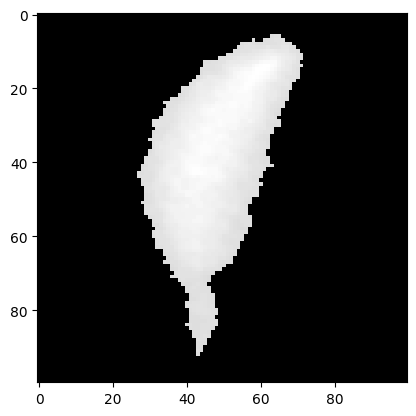

In [ ]:
##NUEVOS DATOS PARA PREDECIR

dataset = 'PREDICTIONS'
DATADIR = "/content/drive/MyDrive/"+ dataset +"/"
CATEGORIES = ['wt','mutant']
wt_folder = '/content/drive/MyDrive/'+dataset+'/wt/'
mutant_folder = '/content/drive/MyDrive/'+dataset+'/mutant/'


for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    print(img)
    # img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_ANYCOLOR)
    img_array = mpimg.imread(os.path.join(path,img))
    # img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_ANYDEPTH)
    # img_array2 = img_array.astype(np.uint8)
    # plt.subplot(121)
    plt.imshow(img_array,cmap ="gray")
    # plt.subplot(122)
    # plt.imshow(img_array2,cmap ="gray")
    plt.show()
    # print(img_array.dtype)
    break
  break



In [ ]:
#Se crean los datos que van a ser utilizados y se hace el resize y normalización para cada una de las imágenes

data_pred = []

def create_data_pred():
  for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        # img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_ANYDEPTH)
        # img_array = img_array.astype(np.uint8)
        img_array = mpimg.imread(os.path.join(path,img))
        new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

        # Normalization
        v_min = np.min(new_array)
        v_max = np.max(new_array)
        # print("Min. and max. values before normalization are {} and {}.".format(v_min, v_max))

        new_array_norm = (new_array - v_min) / (v_max - v_min)
        # print("Min. and max. values after normalization are {} and {}.".format(np.min(new_array_norm), np.max(new_array_norm)))
        data_pred.append([(new_array_norm), class_num])

      except Exception as e:
        pass
create_data_pred()




<ipython-input-13-9f971ec47bc8>:21: RuntimeWarning: invalid value encountered in divide
  new_array_norm = (new_array - v_min) / (v_max - v_min)


Min. and max. values before normalization are 0 and 131.
Min. and max. values after normalization are 0.0 and 1.0.


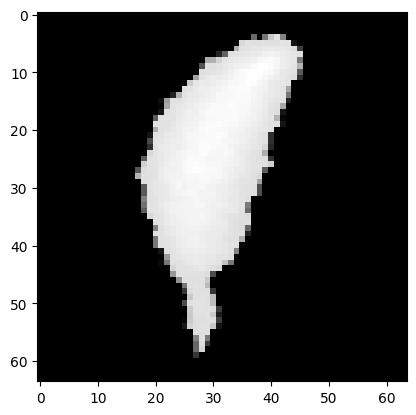

In [ ]:
# Resize a tamaño 64x64
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))

#Se muestra una imagen con la nueva resolución como ejemplo:
plt.imshow(new_array,cmap ='gray')

# normalización min max:

v_min = np.min(new_array)
v_max = np.max(new_array)
print("Min. and max. values before normalization are {} and {}.".format(v_min, v_max))

# Normalization

new_array_norm = (new_array - v_min) / (v_max - v_min)
print("Min. and max. values after normalization are {} and {}.".format(np.min(new_array_norm), np.max(new_array_norm)))

In [ ]:

X_pred = []
y_pred = []

for features, label in data_pred:
  X_pred.append(features)
  y_pred.append(label)
X_pred = np.array(X_pred).reshape(-1, IMG_SIZE, IMG_SIZE,1)

X_pred = np.array(X_pred)
y_pred = np.array(y_pred)

In [ ]:
##### para VGG16
X_pred = np.dstack([X_pred]*3)
#y_pred = np.dstack([y_pred ]*3)

X_pred = X_pred.reshape(-1, 64,64,3)
#y_pred= y_pred.reshape (-1,64,64,3)



In [ ]:
print(np.array(y_pred))
len(y_pred)


[0 0 0 ... 0 0 0]


2149

In [ ]:
import numpy as np
from keras.models import load_model

# Load the trained model (either the entire model or just the weights)
# Replace 'path/to/saved/model.h5' with the correct path to your saved model

#model = load_model('/content/drive/MyDrive/weights_model/epoch_200/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_COHESINAS/epoch_103/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_MODELO_1/epoch_250/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_1/epoch_45/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_2/epoch_55/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_3_ROT/epoch_294/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_4_ROT/epoch_600/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF5/epoch_70/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_6_PAPER/epoch_53/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_6_VGG16/epoch_50/model.h5')
#model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_6_PAPER_VERSION2/epoch_53/model.h5')
model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_6_PAPER_MARZO/epoch_78/model.h5')


# Preprocess new data (replace this with your actual preprocessing steps)
# Assuming 'new_data' is your new data in an appropriate format
# You should preprocess 'new_data' to match the preprocessing applied to the training data
preprocessed_data = X_pred

# Use the model to predict on the preprocessed data
predictions = model.predict(preprocessed_data)

# 'predictions' will contain the model's predictions for the new data
#print('Predictions:', predictions)

# Threshold for classification
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
binary_predictions = (predictions >= threshold).astype(int)

# Print the original probabilities and the binary predictions
#for i in range(len(predictions)):
#    print(f"Prediction: {predictions[i][0]:.4f} -> Binary prediction: {binary_predictions[i][0]}")


# Calculate the count of each label (0 and 1)
count_label_0 = np.sum(binary_predictions == 0)
count_label_1 = np.sum(binary_predictions == 1)

# Calculate the percentage of each label
total_samples = len(binary_predictions)
percent_label_0 = (count_label_0 / total_samples) * 100
percent_label_1 = (count_label_1 / total_samples) * 100

# Print the percentages
print(f"Percentage of Label 0: {percent_label_0:.2f}%")
print(f"Percentage of Label 1: {percent_label_1:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Percentage of Label 0: 71.38%
Percentage of Label 1: 28.62%


In [ ]:
model = load_model('/content/drive/MyDrive/weights_model/BATCH_DEF_6_PAPER/epoch_53/model.h5')


In [ ]:
print("Mean: ",np.mean(predictions))
print("Median:",np.median(predictions))

Mean:  0.62194526
Median: 0.6614366


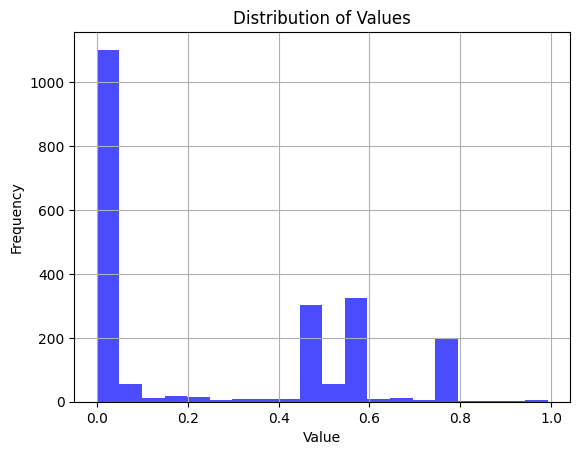

In [ ]:
mi_array = predictions
plt.hist(mi_array, bins=20, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Values')
plt.grid(True)
plt.savefig('histogram_figure.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

# Define a range of threshold values to test
thresholds = np.linspace(0, 1, 100)

# Evaluate F1-score for each threshold and choose the best one
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
    y_predictions = (predictions > threshold).astype(int)
    f1 = f1_score(y_pred, y_predictions)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best F1-score:", best_f1)
print("Best Threshold:", best_threshold)

Best F1-score: 0
Best Threshold: 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Define un rango de umbrales para probar
thresholds = np.linspace(0, 1, 100)

# Inicializa variables para almacenar los mejores valores y umbrales
best_accuracy = 0
best_auc_roc = 0
best_accuracy_threshold = 0
best_auc_roc_threshold = 0

# Itera sobre los umbrales y calcula las métricas
for threshold in thresholds:
    # Convierte las probabilidades en predicciones binarias basadas en el umbral
    y_predictions = (predictions > threshold).astype(int)

    # Calcula las métricas para el umbral actual
    accuracy = accuracy_score(y_pred, y_predictions)
    auc_roc = roc_auc_score(y_pred, y_predictions)

    # Actualiza los mejores valores y umbrales
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_threshold = threshold

    if auc_roc > best_auc_roc:
        best_auc_roc = auc_roc
        best_auc_roc_threshold = threshold

print("Best Accuracy:", best_accuracy)
print("Best Accuracy Threshold:", best_accuracy_threshold)

print("Best AUC-ROC:", best_auc_roc)
print("Best AUC-ROC Threshold:", best_auc_roc_threshold)

Best Accuracy: 1.0
Best Accuracy Threshold: 1.0
Best AUC-ROC: 0
Best AUC-ROC Threshold: 0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:375: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.10/dist

In [ ]:
!pip install sklearn_evaluation

In [ ]:
y_pred_keras4 = model.predict(X_pred).ravel()

fpr_keras4, tpr_keras4, thresholds_keras4 = roc_curve(y_pred, y_pred_keras4)

auc_keras4 = auc(fpr_keras4, tpr_keras4)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras4, tpr_keras4, label='Keras4 (area = {:.3f})'.format(auc_keras4))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.savefig('ROC_curve.pdf', format='pdf', bbox_inches='tight')

plt.show()


NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import roc_auc_score

# Calcular el AUC solo para la clase positiva
roc_auc = roc_auc_score(y_pred, model.predict(X_pred).ravel())

# Imprimir el AUC
print("AUC:", roc_auc)




39/39 [==============================] - 0s 5ms/step
AUC: 0.6976243111623734
0.6976243111623734


7. Comparación del rendimiento de las  redes neuronales en el conjunto test mediante  curvas ROC y
métricas de calidad.


Se muestran también las curvas de accuracy y loss:

In [ ]:
#model 4 TRAINING TEST, NO VALIDATION

y_pred_keras4 = keras_model4.predict(x_test).ravel()

fpr_keras4, tpr_keras4, thresholds_keras4 = roc_curve(y_test, y_pred_keras4)

auc_keras4 = auc(fpr_keras4, tpr_keras4)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras4, tpr_keras4, label='Keras4 (area = {:.3f})'.format(auc_keras4))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.savefig('ROC_curve.pdf', format='pdf', bbox_inches='tight')

plt.show()


NameError: name 'keras_model4' is not defined

In [ ]:
def plot_prediction(n_epochs, mfit):
    N = n_epochs
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')

    ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")

    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.savefig('grafico_epochs.pdf', format='pdf', bbox_inches='tight')

    plt.show()


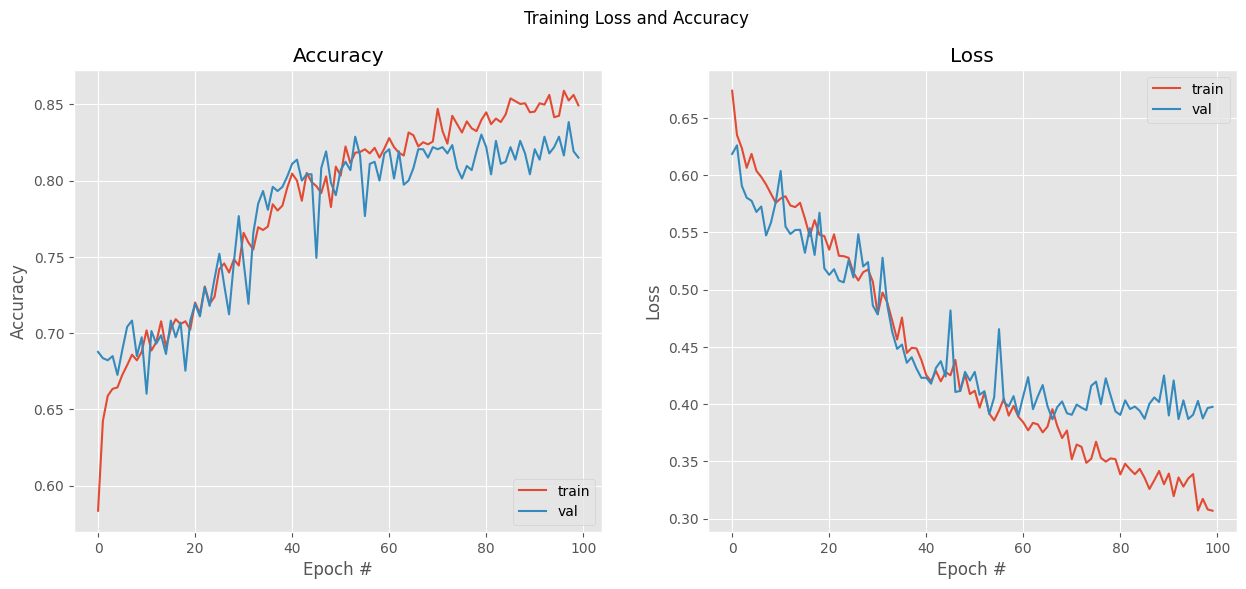

In [ ]:
plot_prediction(100, history)
#plot_prediction(150, mfit4)
#plot_prediction(100, mfit4)



Se utilizan las métricas y matrices de confusión para visualizar los resultados de las redes con mejores resultados:

In [ ]:
###### FIGURA TABLAS DE PRECISION MODELO NORMAL SIN PREDICCIONES
y_pred = keras_model4.predict(x_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names = ['(Class 0)','(Class 1)']))

cm = confusion_matrix(y_test,y_pred)
cm

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (10,10))
#sns.heatmap(cm,cmap= "RdBu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

NameError: name 'keras_model4' is not defined

In [ ]:
###### FIGURA TABLAS DE PRECISION VALIDATION SETS

y2_pred = model.predict(X_pred)
y2_pred = np.round(y2_pred).astype(int).reshape(-1)

from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_pred, y2_pred, target_names = ['(Class 0)','(Class 1)']))

cm = confusion_matrix(y_pred,y2_pred)
cm

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (10,10))
#sns.heatmap(cm,cmap= "RdBu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

   (Class 0)       1.00      0.37      0.54        73
   (Class 1)       0.00      0.00      0.00         0

    accuracy                           0.37        73
   macro avg       0.50      0.18      0.27        73
weighted avg       1.00      0.37      0.54        73



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

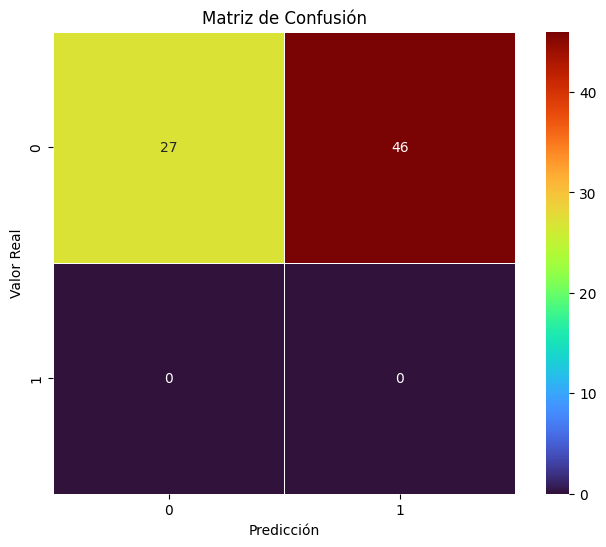

In [ ]:
##### FIGURA MATRIZ CONFUSION

import seaborn as sns
import matplotlib.pyplot as plt

# Supongo que ya tienes la matriz de confusión 'cm' creada

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='turbo', linewidths=.5, cbar=True, square=True)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.savefig('CM_grafico.pdf', format='pdf', bbox_inches='tight')

plt.show()

In [ ]:
for layer in modelo.layers:
    print(layer.name)



random_flip_1
conv2d_4
conv2d_5
max_pooling2d_3
dropout_4
conv2d_6
max_pooling2d_4
dropout_5
conv2d_7
max_pooling2d_5
dropout_6
flatten_1
dense_2
dropout_7
dense_3
